In [1]:
import os
#os.environ["JAX_PLATFORM_NAME"] = "cpu"
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from pennylane import AngleEmbedding, StronglyEntanglingLayers, RandomLayers
import pennylane as qml
import os
import jax
from jax import numpy as jnp
import equinox as eqx
import time
from tqdm import tqdm
import optax
import tensorflow as tf
from jaxtyping import Array, Float, PyTree
from collections import deque

In [2]:
print(jax.devices())

[cuda(id=0)]


In [3]:
key = jax.random.PRNGKey(0)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
x_train = x_train[:50_000]
y_train = y_train[:50_000]

x_test = x_test[:10_000]
y_test = y_test[:10_000]

In [6]:
y_test = y_test.astype(np.float32)
y_train = y_train.astype(np.float32)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [7]:
x_train = jnp.expand_dims(x_train, axis=-1)
x_test = jnp.expand_dims(x_test, axis=-1)

In [8]:
x_train = np.transpose(x_train, (0, 3, 1, 2))
x_test = np.transpose(x_test, (0, 3, 1, 2))

In [9]:
y_train = jax.nn.one_hot(y_train, 10)
y_test = jax.nn.one_hot(y_test, 10)

In [10]:
num_qubits = 8
in_channel = 2
kernel_size = [2, 2]

In [11]:
device = qml.device("default.qubit.jax", wires=num_qubits)

@jax.jit
@qml.qnode(device, interface="jax")
def quantum_conv_circuit(inputs, weights):
    AngleEmbedding(inputs, wires=range(num_qubits))
    
    for weight_set, cell_qubit in enumerate(range(0, num_qubits, in_channel)):
        
        for channel_qubit in range(0, in_channel):
            if cell_qubit + channel_qubit != cell_qubit:
                qml.CNOT(wires=[cell_qubit + channel_qubit, cell_qubit])
        qml.Rot(weights[weight_set, 0], weights[weight_set, 1], weights[weight_set, 2], wires=cell_qubit)
        
        if cell_qubit > 0:
            qml.CNOT(wires=[cell_qubit, 0])
    
    qml.Rot(weights[-1, 0], weights[-1, 1], weights[-1, 2], wires=0)
    #RandomLayers(weights, wires=range(self.num_qubits))
    return qml.expval(qml.PauliZ(wires=0))

In [12]:
weights = jax.random.normal(jax.random.PRNGKey(0), (sum(kernel_size) + 1, 3))

In [13]:
quantum_conv_circuit(jnp.array([2, 2, 3, 2, 5, 6, 7, 8]), weights)

Array(0.05004174, dtype=float32)

/tmp/ipykernel_4818/2255298493.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


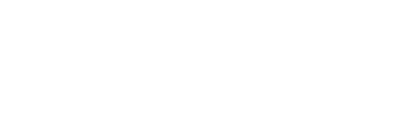

In [14]:
fig, ax = qml.draw_mpl(quantum_conv_circuit)(jnp.array([2, 2, 3, 2, 5, 6, 7, 8]), weights)
fig.show()

In [15]:
class QuantumConv2dLayer(eqx.Module):
    filter_size: int
    circuit_length: int
    padding_mode: str
    weight: jax.Array
    num_qubits: int
    quantum_conv_circuit: list
    kernel_size: tuple[int, int]
    stride: tuple[int, int]
    
    def __init__(self, filter_size, circuit_length, kernel_size, stride, padding_mode, in_channel):
        super().__init__()
        self.filter_size = filter_size
        self.circuit_length = circuit_length
        self.padding_mode = padding_mode
        
        self.num_qubits = in_channel * kernel_size[0] * kernel_size[1]
        self.weight = jax.random.normal(jax.random.PRNGKey(0), (filter_size, kernel_size[0] + kernel_size[1] + 1, 3))
        # self.weight = jax.random.normal(jax.random.PRNGKey(0), (filter_size, circuit_length, self.num_qubits))
        self.kernel_size = kernel_size
        self.stride = stride

        device = qml.device("default.qubit.jax", wires=self.num_qubits)
        @jax.jit
        @qml.qnode(device, interface="jax")
        def quantum_conv_circuit(inputs, weights):
            AngleEmbedding(inputs, wires=range(self.num_qubits))
            for weight_set, cell_qubit in enumerate(range(0, self.num_qubits, in_channel)):

                for channel_qubit in range(0, in_channel):
                    if cell_qubit + channel_qubit != cell_qubit:
                        qml.CNOT(wires=[cell_qubit + channel_qubit, cell_qubit])
                qml.Rot(weights[weight_set, 0], weights[weight_set, 1], weights[weight_set, 2], wires=cell_qubit)

                if cell_qubit > 0:
                    qml.CNOT(wires=[cell_qubit, 0])

                qml.Rot(weights[-1, 0], weights[-1, 1], weights[-1, 2], wires=0)
            # RandomLayers(weights, wires=range(self.num_qubits))
            return qml.expval(qml.PauliZ(wires=0))

        self.quantum_conv_circuit = [quantum_conv_circuit]
        
    @eqx.filter_jit
    def apply_on_batch(self, inputs):
        # Apply the quantum circuit to each patch
        inputs = jnp.transpose(inputs)
        outputs = []
                
        for i in range(self.filter_size):
            
            outputs.append(
                jnp.expand_dims(
                    jax.vmap(
                        self.quantum_conv_circuit[0], in_axes=(0, None)
                    )(inputs, self.weight[i]),
                    axis=0
                )
            )
        return jnp.concatenate(outputs, axis=0)
    
    @eqx.filter_jit
    def __call__(self, inputs):
        # Extract patches
        inputs = jnp.expand_dims(inputs, axis=0)
        patches = jax.lax.conv_general_dilated_patches(inputs, self.kernel_size, self.stride, self.padding_mode)
        patches_shape = patches.shape
        patches_flat = patches.reshape(patches_shape[0], patches_shape[1], patches_shape[2] * patches_shape[3])

        # Apply the quantum circuit on each patch
        output = jax.vmap(self.apply_on_batch)(patches_flat)
        output_shape = patches_shape
        
        output_shape = (self.filter_size, output_shape[2], output_shape[3])        
        # Reshape the output
        return output.reshape(output_shape)


#quantum_layer = QuantumConv2dLayer(filter_size=2, circuit_length=3, kernel_size=(2, 2), stride=(2, 2), padding_mode='SAME', in_channel=1)

In [16]:
#quantum_layer((np.random.random((1, 28, 28))))

In [17]:
class HybrideModel(eqx.Module):
    layers: list
    
    def __init__(self, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        self.layers = [
            eqx.nn.Conv2d(1, 1, kernel_size=4, key=key1, stride=3),
            jax.nn.sigmoid,
            QuantumConv2dLayer(filter_size=8, circuit_length=1, kernel_size=(3, 3), stride=(2, 2), padding_mode='VALID', in_channel=1),
            eqx.nn.Conv2d(8, 12, kernel_size=2, key=key3, stride=2),
            jax.nn.relu,
            jnp.ravel,
            eqx.nn.Linear(48, 10, key=key3),
            jax.nn.softmax
        ]
        
    @eqx.filter_jit
    def __call__(self, x):
        
        for layer in self.layers:
            x = layer(x)
        return x
    
key, subkey = jax.random.split(key, 2)
model = HybrideModel(subkey)

In [18]:
@eqx.filter_jit
def categorical_crossentropy(model, inputs, targets):
    
    y_pred = jax.vmap(model)(inputs)
    
    y_pred = jnp.clip(y_pred, 1e-7, 1 - 1e-7)
    
    loss = -jnp.sum(targets * jnp.log(y_pred), axis=-1)
    
    return jnp.mean(loss), y_pred

@eqx.filter_jit
def categorical_accuracy(y_true, y_pred):
    true_labels = jnp.argmax(y_true, axis=-1)
    predicted_labels = jnp.argmax(y_pred, axis=-1)

    # Comparer les indices pour calculer la précision
    return jnp.mean(true_labels == predicted_labels)
    

@eqx.filter_jit
def train_step(model, opt_state, inputs, target):
    
    (loss_value, y_pred), grads = eqx.filter_value_and_grad(categorical_crossentropy, has_aux=True)(model, inputs, target)
    
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    
    accuracy = categorical_accuracy(target, y_pred)
    
    
    return model, opt_state, loss_value, accuracy

In [19]:
def batch(array, batch_size):
    return np.array_split(array, np.ceil(len(array) / batch_size))

In [20]:
#optim = optax.sgd(0.0001, 0.9, True)
optim = optax.adamax(0.002)
opt_state = optim.init(eqx.filter(model, eqx.is_array))
epochs = 30
batch_size = 16

In [21]:
x_train_batch = batch(x_train, batch_size=batch_size)
y_train_batch = batch(y_train, batch_size=batch_size)

x_test_batch = batch(x_test, batch_size=batch_size)
y_test_batch = batch(y_test, batch_size=batch_size)

In [22]:
for step in range(epochs):
    accuracys = deque()
    losss = deque()
    for (x_batch, y_batch) in tqdm(zip(x_train_batch, y_train_batch), total=len(x_train_batch)):
        model, opt_state, loss_val, accuracy = train_step(model, opt_state, x_batch, y_batch)
        accuracys.append(accuracy)
        losss.append(loss_val)
        
    print(f"Loss: {np.mean(losss)}")
    print(f"Accuracy: {np.mean(accuracys)}")

100%|██████████| 3125/3125 [01:01<00:00, 50.99it/s]


Loss: 1.2997809648513794
Accuracy: 0.5757799744606018


100%|██████████| 3125/3125 [00:44<00:00, 69.99it/s]


Loss: 0.7693491578102112
Accuracy: 0.7530800104141235


100%|██████████| 3125/3125 [00:44<00:00, 70.28it/s]


Loss: 0.6453771591186523
Accuracy: 0.7932199835777283


100%|██████████| 3125/3125 [00:44<00:00, 70.77it/s]


Loss: 0.5826661586761475
Accuracy: 0.8143600225448608


100%|██████████| 3125/3125 [00:44<00:00, 70.78it/s]


Loss: 0.5375463962554932
Accuracy: 0.8283200263977051


100%|██████████| 3125/3125 [00:44<00:00, 70.46it/s]


Loss: 0.5007834434509277
Accuracy: 0.8391199707984924


100%|██████████| 3125/3125 [00:44<00:00, 70.37it/s]


Loss: 0.4716348946094513
Accuracy: 0.8492000102996826


100%|██████████| 3125/3125 [00:44<00:00, 69.54it/s]


Loss: 0.44506171345710754
Accuracy: 0.8596400022506714


100%|██████████| 3125/3125 [00:44<00:00, 69.77it/s]


Loss: 0.42644792795181274
Accuracy: 0.8659200072288513


100%|██████████| 3125/3125 [00:44<00:00, 70.05it/s]


Loss: 0.40946754813194275
Accuracy: 0.8712800145149231


100%|██████████| 3125/3125 [00:44<00:00, 70.34it/s]


Loss: 0.3924939036369324
Accuracy: 0.876579999923706


100%|██████████| 3125/3125 [00:44<00:00, 70.35it/s]


Loss: 0.3746582865715027
Accuracy: 0.8830999732017517


100%|██████████| 3125/3125 [00:44<00:00, 70.35it/s]


Loss: 0.36069977283477783
Accuracy: 0.887719988822937


100%|██████████| 3125/3125 [00:44<00:00, 70.36it/s]


Loss: 0.3489501178264618
Accuracy: 0.8917400240898132


100%|██████████| 3125/3125 [00:44<00:00, 70.34it/s]


Loss: 0.3382526934146881
Accuracy: 0.895579993724823


100%|██████████| 3125/3125 [00:44<00:00, 70.35it/s]


Loss: 0.3288235664367676
Accuracy: 0.8994600176811218


100%|██████████| 3125/3125 [00:44<00:00, 70.33it/s]


Loss: 0.3193679749965668
Accuracy: 0.9023000001907349


100%|██████████| 3125/3125 [00:44<00:00, 70.35it/s]


Loss: 0.3116987347602844
Accuracy: 0.9047200083732605


100%|██████████| 3125/3125 [00:44<00:00, 70.35it/s]


Loss: 0.30415108799934387
Accuracy: 0.9074199795722961


100%|██████████| 3125/3125 [00:44<00:00, 70.33it/s]


Loss: 0.29755282402038574
Accuracy: 0.9090399742126465


100%|██████████| 3125/3125 [00:44<00:00, 70.34it/s]


Loss: 0.29210150241851807
Accuracy: 0.9103599786758423


100%|██████████| 3125/3125 [00:44<00:00, 70.36it/s]


Loss: 0.28773054480552673
Accuracy: 0.9120200276374817


100%|██████████| 3125/3125 [00:44<00:00, 70.35it/s]


Loss: 0.28211578726768494
Accuracy: 0.9134399890899658


100%|██████████| 3125/3125 [00:44<00:00, 70.35it/s]


Loss: 0.27743253111839294
Accuracy: 0.9150199890136719


100%|██████████| 3125/3125 [00:44<00:00, 70.33it/s]


Loss: 0.27198320627212524
Accuracy: 0.9172400236129761


100%|██████████| 3125/3125 [00:44<00:00, 70.34it/s]


Loss: 0.2681012749671936
Accuracy: 0.9177200198173523


100%|██████████| 3125/3125 [00:44<00:00, 70.36it/s]


Loss: 0.26454681158065796
Accuracy: 0.9185600280761719


100%|██████████| 3125/3125 [00:44<00:00, 70.34it/s]


Loss: 0.26073750853538513
Accuracy: 0.9201599955558777


100%|██████████| 3125/3125 [00:44<00:00, 70.34it/s]


Loss: 0.25727981328964233
Accuracy: 0.9214800000190735


100%|██████████| 3125/3125 [00:44<00:00, 70.36it/s]


Loss: 0.2534020245075226
Accuracy: 0.9226199984550476


Loss: 1.5282968282699585
Accuracy: 0.49437999725341797

Loss: 0.9188337326049805
Accuracy: 0.6870800256729126

Loss: 0.8464434146881104
Accuracy: 0.7142199873924255

Loss: 0.7995278239250183
Accuracy: 0.7277200222015381

Loss: 0.7739561200141907
Accuracy: 0.7372599840164185